In [1]:
!pip install laspy

## Imports

In [1]:
import geopandas as gpd
import laspy
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import seaborn as sns
import warnings
from mpl_toolkits.basemap import Basemap
import os
import string

## Data visualization & pre-processing

In [2]:
field_survey = gpd.read_file("/Users/aleksandra/Documents/UNI/lidar-point-transformer/data/field_survey.geojson")
field_survey.head()

plot  tree_no species    d1    d2    dbh   age  height  angle comment  \
0   1.0      1.0   Birch  47.2  46.2  46.70   NaN    26.5    0.0    None   
1   1.0      2.0   Aspen  27.9  29.1  28.50   NaN     NaN    0.0    None   
2   1.0      3.0     Fir  12.1  13.0  12.55   NaN     NaN    0.0    None   
3   1.0      4.0   Aspen  23.3  23.7  23.50  69.0    27.4    0.0    None   
4   1.0      5.0   Aspen  23.2  31.3  27.25   NaN     NaN    0.0    None   

                         geometry  
0   POINT (547075.84 6450425.243)  
1  POINT (547074.299 6450419.542)  
2  POINT (547077.454 6450419.994)  
3   POINT (547078.211 6450419.02)  
4  POINT (547074.669 6450415.573)

In [7]:
field_survey.shape

(3602, 11)

Upon a short analysis, the column 'tree_no' seems to be the equivalent of an index, so let us remove it:

In [3]:
df = field_survey.drop(columns=['tree_no'])
df.head()

plot species    d1    d2    dbh   age  height  angle comment  \
0   1.0   Birch  47.2  46.2  46.70   NaN    26.5    0.0    None   
1   1.0   Aspen  27.9  29.1  28.50   NaN     NaN    0.0    None   
2   1.0     Fir  12.1  13.0  12.55   NaN     NaN    0.0    None   
3   1.0   Aspen  23.3  23.7  23.50  69.0    27.4    0.0    None   
4   1.0   Aspen  23.2  31.3  27.25   NaN     NaN    0.0    None   

                         geometry  
0   POINT (547075.84 6450425.243)  
1  POINT (547074.299 6450419.542)  
2  POINT (547077.454 6450419.994)  
3   POINT (547078.211 6450419.02)  
4  POINT (547074.669 6450415.573)

Let's check for missing values:

In [6]:
missing_values_table = df.isnull().sum().reset_index()
missing_values_table.columns = ['Column', 'Missing count']
missing_values_table['Missing percentage'] = (missing_values_table['Missing count'] / len(field_survey)) * 100

print(missing_values_table)

     Column  Missing count  Missing percentage
0      plot              0            0.000000
1   species              0            0.000000
2        d1              0            0.000000
3        d2              0            0.000000
4       dbh              0            0.000000
5       age           3231           89.700167
6    height           2806           77.901166
7     angle              0            0.000000
8   comment           3329           92.420877
9  geometry              0            0.000000


There is not much we can do about the missing values except potentially remove the columns concerned (there are too many missing values to replace them with the mean, median or mode of the column), however just in case we may need some of that data, we are going to keep them.

In [9]:
df[df['species'] == 'Pine'].shape[0]

1

Let's visualise a few columns:

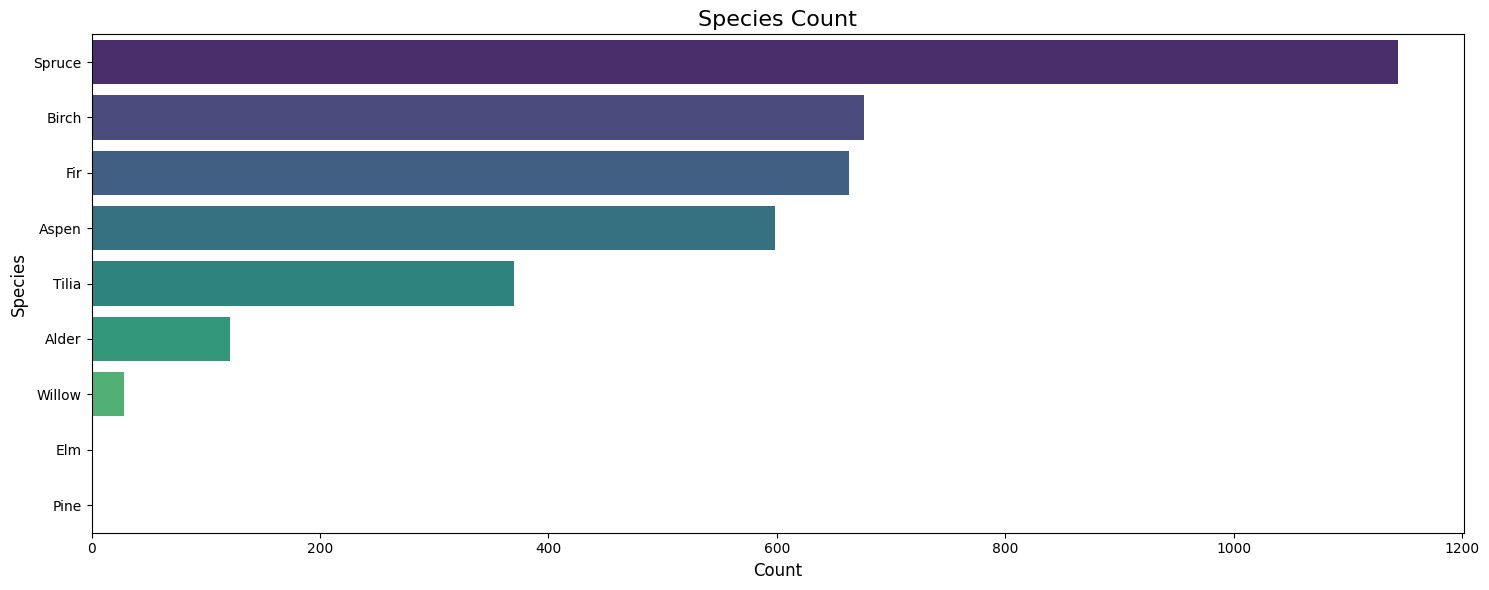

In [ ]:
species_counts = field_survey['species'].value_counts()

plt.figure(figsize=(15, 6))
sns.barplot(y=species_counts.index, x=species_counts.values, palette="viridis")
plt.title("Species Count", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Species", fontsize=12)
plt.tight_layout()
plt.show()

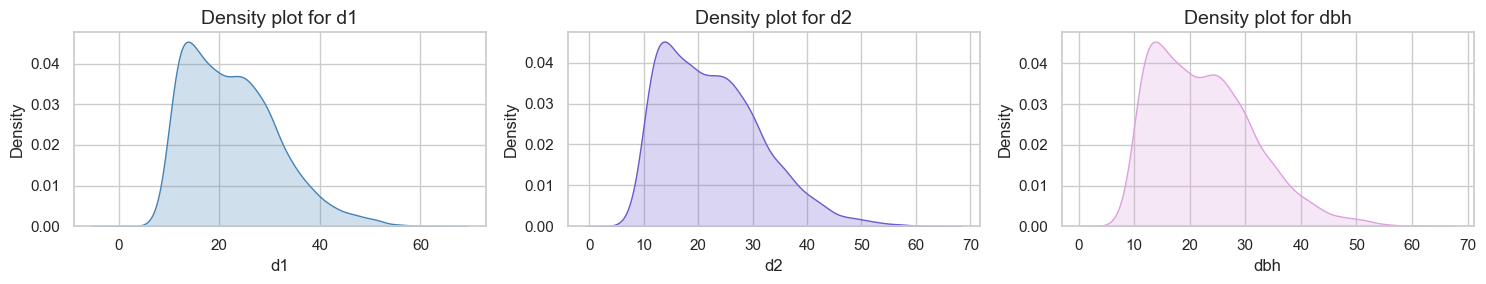

In [60]:
warnings.filterwarnings("ignore", category=FutureWarning)

plt.figure(figsize=(15, 3))

# Plot density for d1
plt.subplot(1, 3, 1)
sns.kdeplot(field_survey['d1'], shade=True, color='steelblue')
plt.title('Density plot for d1', fontsize=14)
plt.xlabel('d1', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Plot density for d2
plt.subplot(1, 3, 2)
sns.kdeplot(field_survey['d2'], shade=True, color='slateblue')
plt.title('Density plot for d2', fontsize=14)
plt.xlabel('d2', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Plot density for dbh
plt.subplot(1, 3, 3)
sns.kdeplot(field_survey['dbh'], shade=True, color='plum')
plt.title('Density plot for dbh', fontsize=14)
plt.xlabel('dbh', fontsize=12)
plt.ylabel('Density', fontsize=12)

plt.tight_layout()
plt.show()


Let's plot all the points on a map:

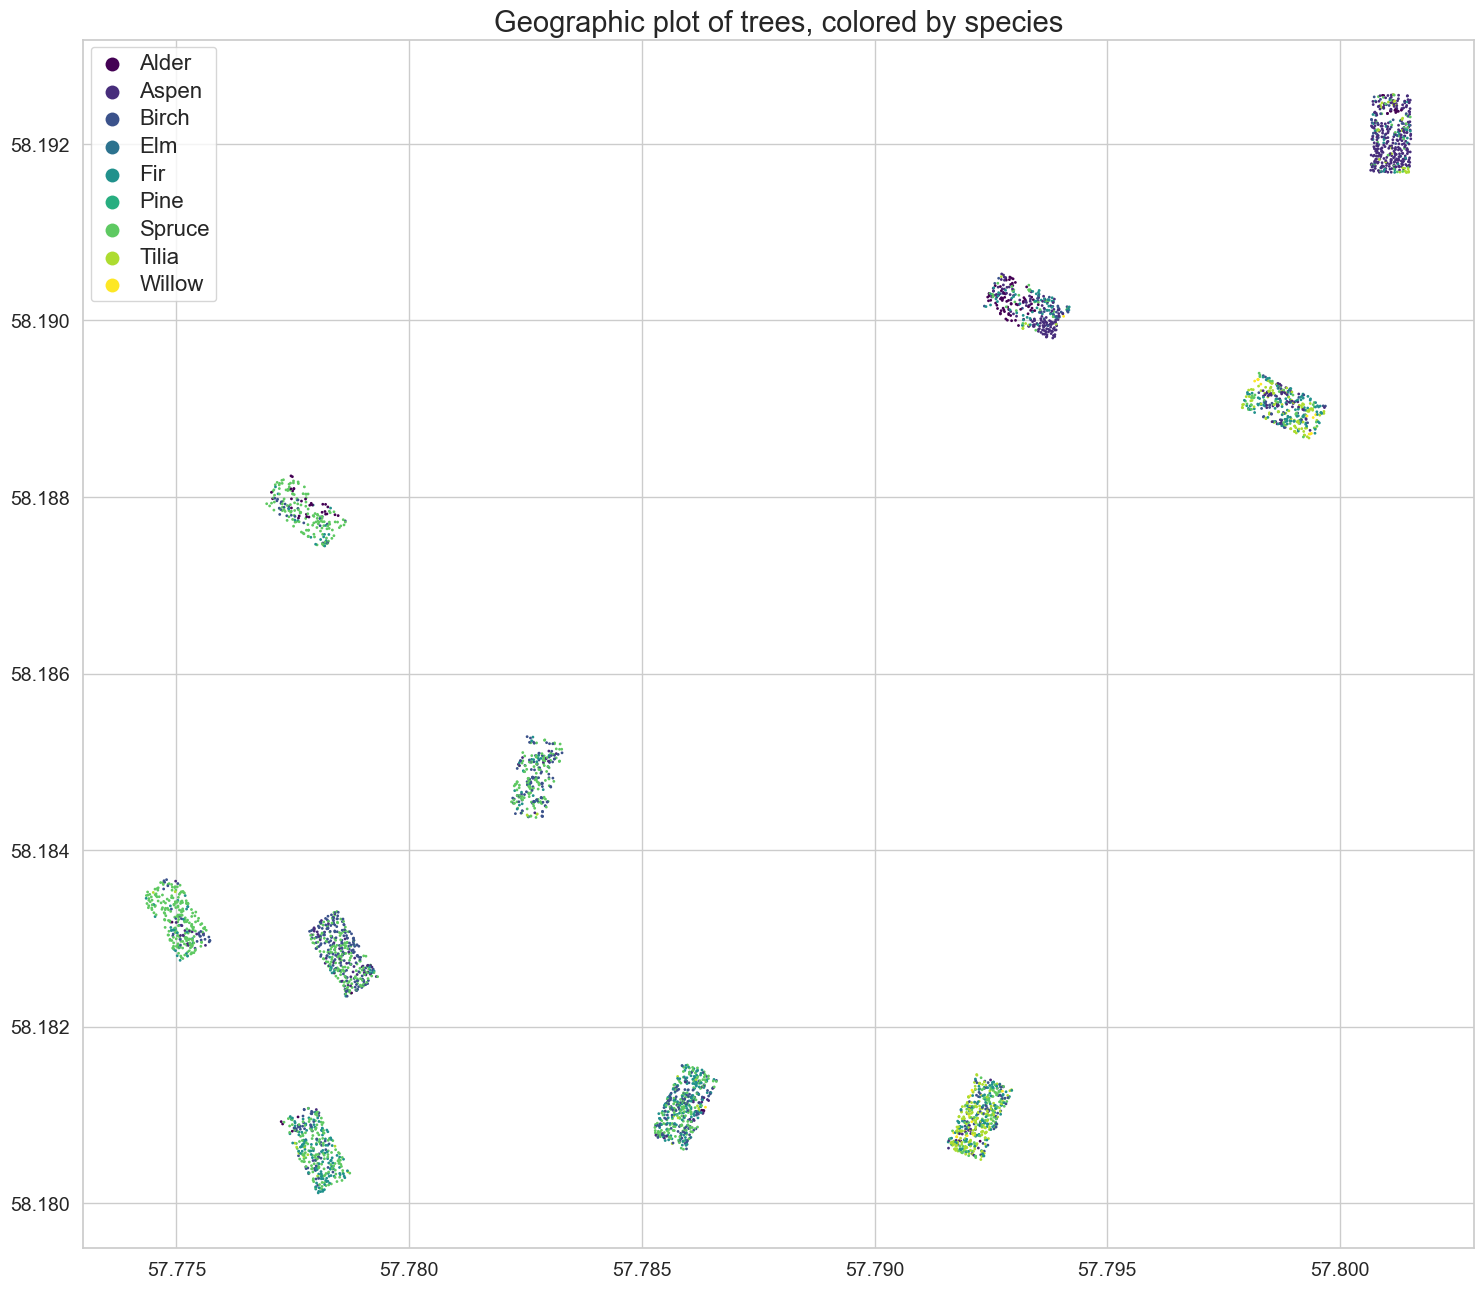

In [79]:
gdf = gpd.GeoDataFrame(field_survey, geometry='geometry')

# Convert to WGS84 (Lat, Long)
gdf = gdf.to_crs(epsg=4326)

# Plot the points colored by species
ax = gdf.plot(column='species', cmap='viridis', legend=True, figsize=(15, 15), markersize=1)

plt.title('Geographic plot of trees, colored by species', fontsize=21)

legend = ax.get_legend()
for label in legend.get_texts():
    label.set_fontsize(16)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.show()

Let's zoom in on each individual rectangle:

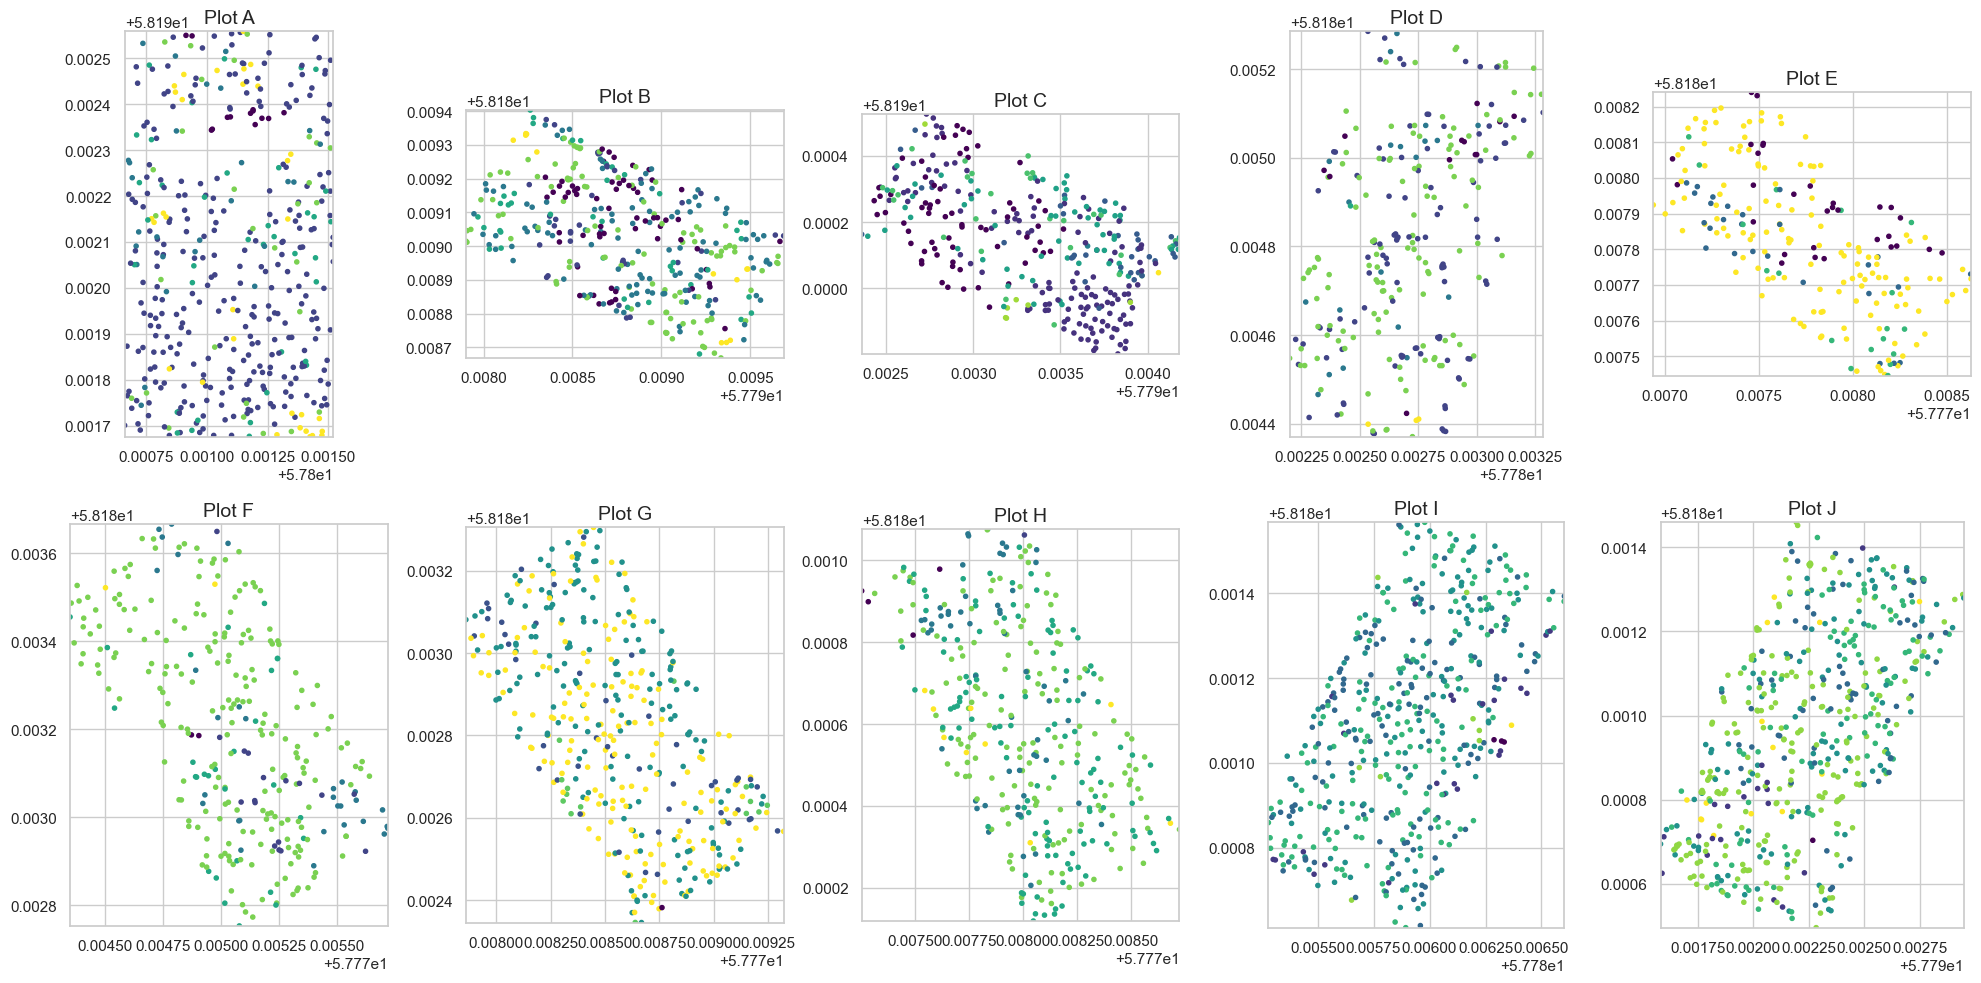

In [ ]:
unique_plots = sorted(gdf['plot'].unique())

# Map plot indices to letters (A, B, C, ...)
# We need to do this because at this point, we don't know which rectangle represents which picture
plot_labels = {plot_id: f"Plot {letter}" for plot_id, letter in zip(unique_plots, string.ascii_uppercase)}

fig, axes = plt.subplots(2,5, figsize=(20, 10), sharex=False, sharey=False)
axes = axes.flatten()

for i, (plot_id, ax) in enumerate(zip(unique_plots, axes)):
    subset = gdf[gdf['plot'] == plot_id]
    
    plot = subset.plot(
        column='species', 
        cmap='viridis', 
        legend=False,  # Disable Geopandas' internal legend
        ax=ax,
        markersize=9
    )
    
    ax.set_title(plot_labels[plot_id], fontsize=14)
    ax.set_xlim(subset.total_bounds[[0, 2]])  # xmin, xmax
    ax.set_ylim(subset.total_bounds[[1, 3]])  # ymin, ymax

for ax in axes[len(unique_plots):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


We immediately recognize 10 rectangles. Now, let's take a look at the pictures:

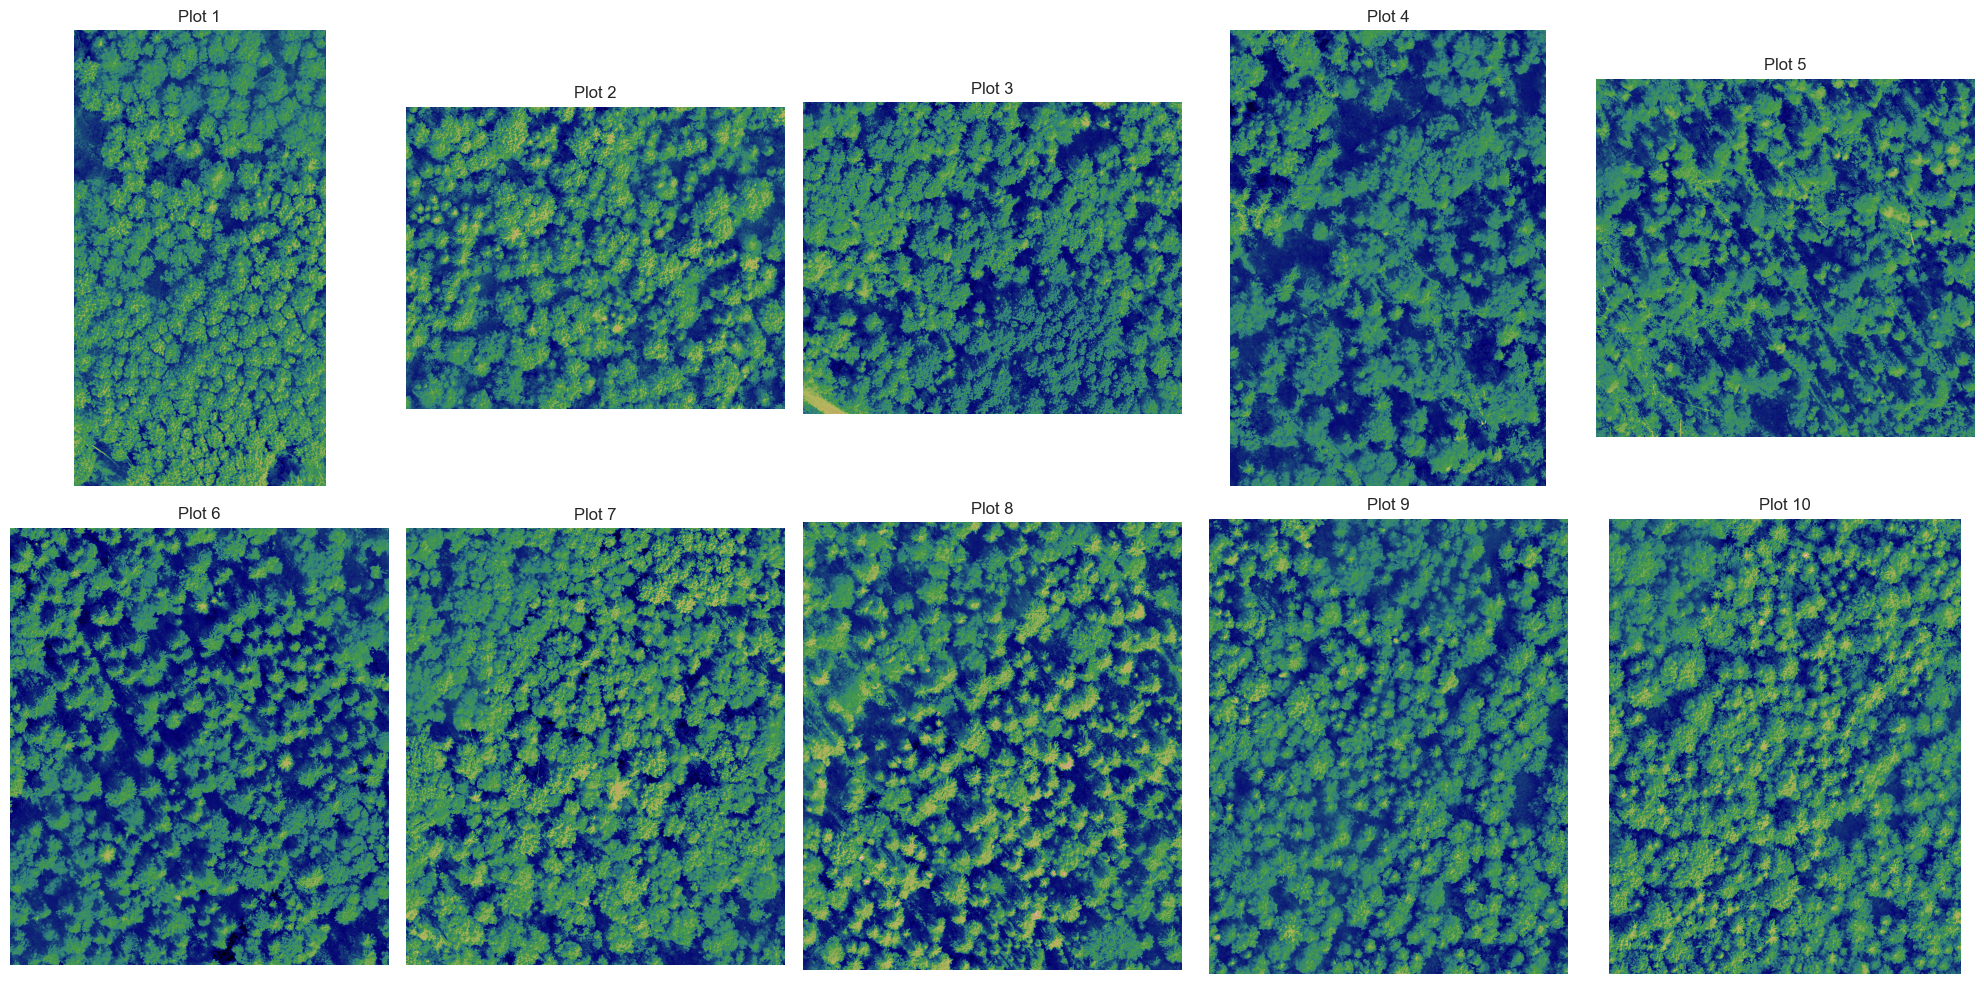

In [97]:
tif_dir = '/Users/aleksandra/Documents/UNI/lidar-point-transformer/data/ortho' 
tiff_files = [os.path.join(tif_dir, f'plot_{i:02d}.tif') for i in range(1, 11)]


fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
axes = axes.flatten() 

for i, tiff_file in enumerate(tiff_files):
    with rasterio.open(tiff_file) as src:
        img = src.read(1)
        
        axes[i].imshow(img, cmap='gist_earth')
        axes[i].set_title(f'Plot {i+1}')
        axes[i].axis('off')

plt.tight_layout()
plt.show()


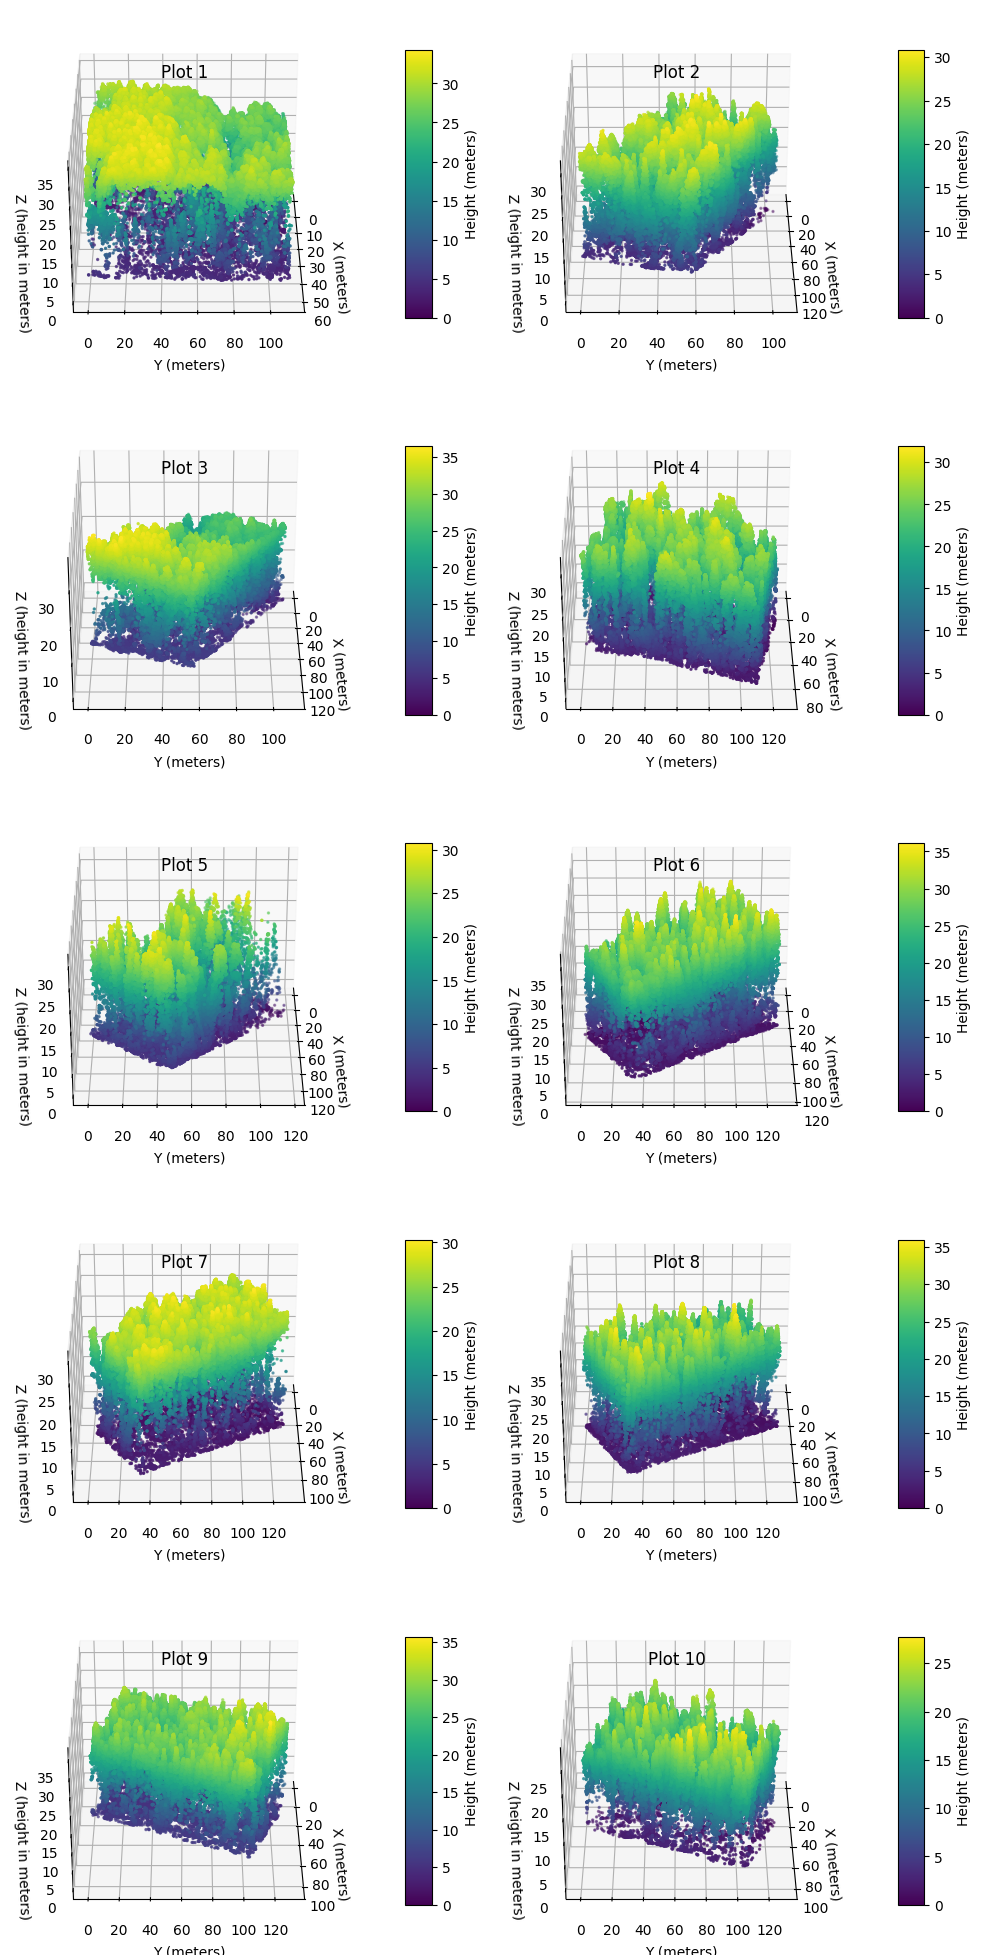

In [ ]:
las_dir = '/Users/aleksandra/Documents/UNI/lidar-point-transformer/data/als'
las_files = [f"{las_dir}/plot_{i:02d}.las" for i in range(1, 11)]

fig = plt.figure(figsize=(10, 20))

for i, file in enumerate(las_files):
    las = laspy.read(file)
    points = np.vstack((las.x, las.y, las.z)).T

    # Normalize the point cloud by subtracting the minimum value
    points -= points.min(axis=0, keepdims=True)

    ax = fig.add_subplot(5, 2, i + 1, projection="3d")
    scatter = ax.scatter(*points.T, c=points[:, 2], s=2, cmap="viridis")  # Color by height (z-axis)
    
    ax.set_xlabel("X (meters)")
    ax.set_ylabel("Y (meters)")
    ax.set_zlabel("Z (height in meters)")
    ax.set_title(f"Plot {i + 1}", y=0.85)
    ax.view_init(elev=30, azim=0)  # Set the view angle
    
    cbar = fig.colorbar(scatter, ax=ax, shrink=0.7, aspect=10, pad=0.1)
    cbar.set_label("Height (meters)")

plt.tight_layout()
plt.show()


Filter irrelevant points (e.g., ground points below a height threshold) and remove residual noise

I would suggest, at least for the beginning, to remove all points below 15-20 meters because I think they are not visible from above anyway

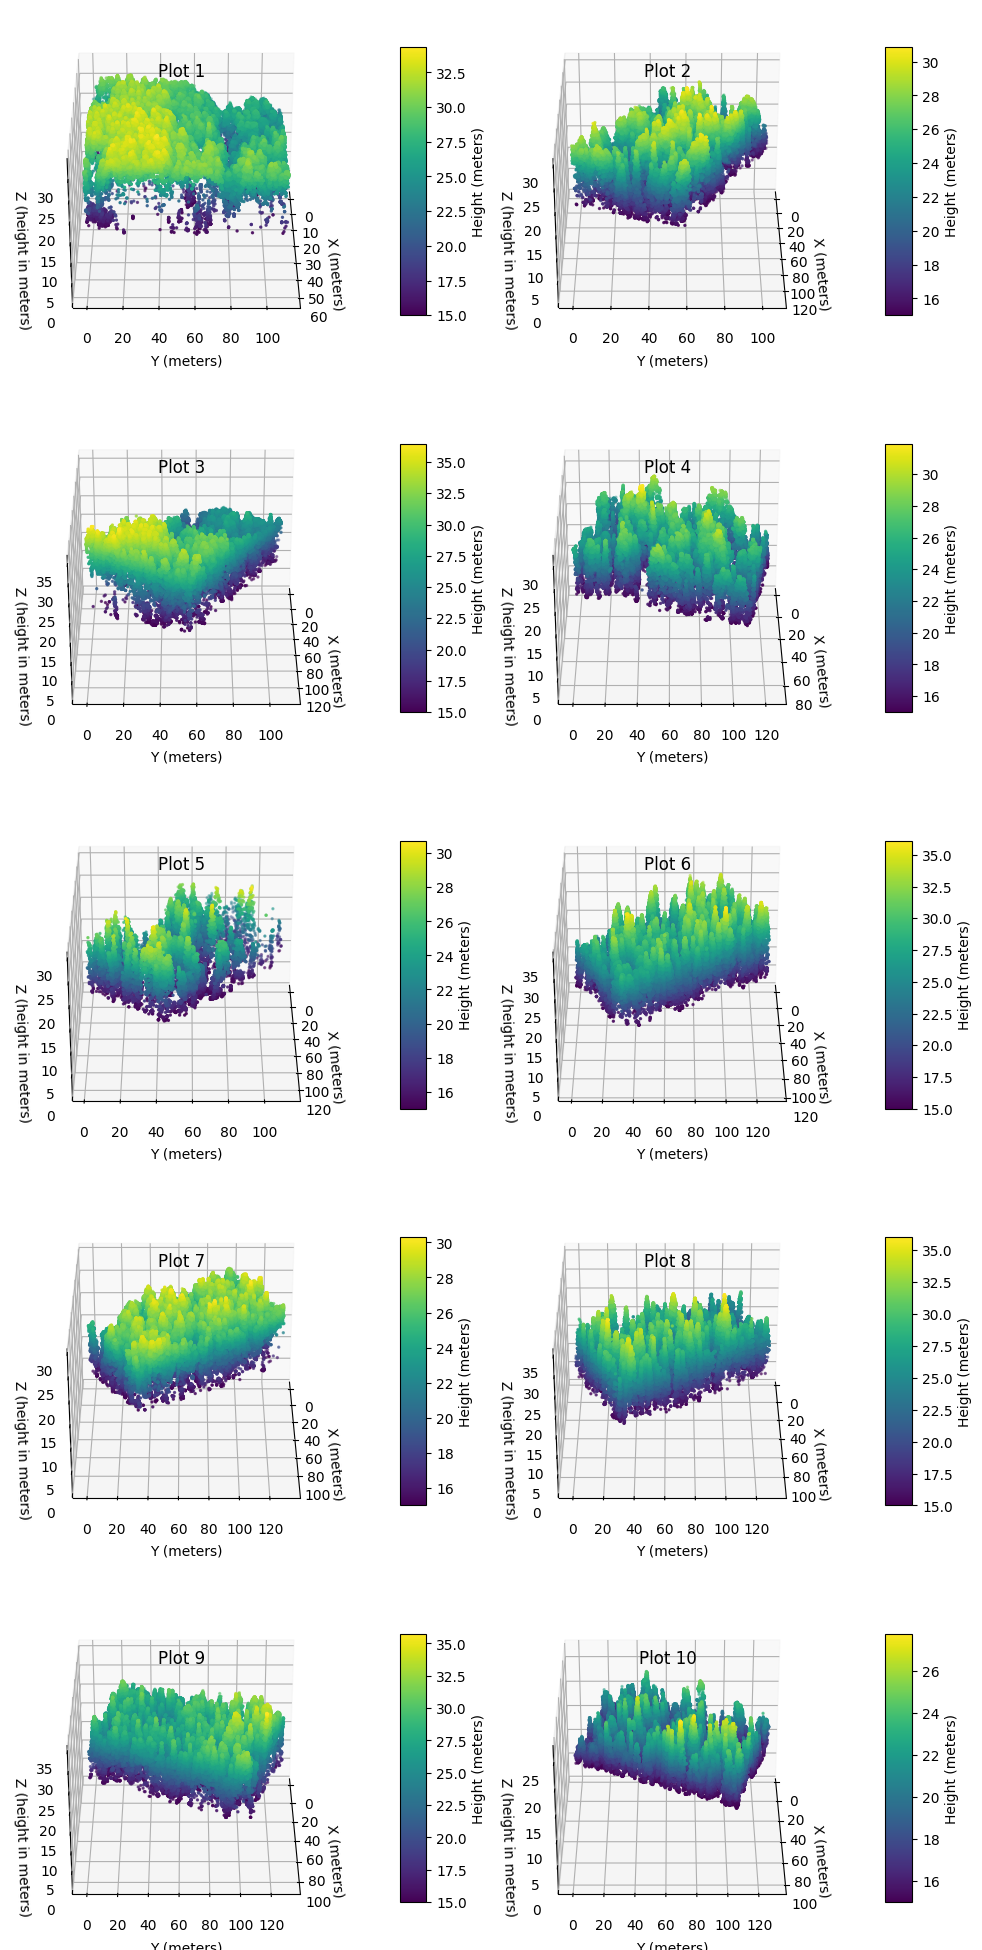

In [19]:
fig = plt.figure(figsize=(10, 20))

for i, file in enumerate(las_files):
    las = laspy.read(file)
    points = np.vstack((las.x, las.y, las.z)).T

    # Normalize the point cloud by subtracting the minimum value
    points -= points.min(axis=0, keepdims=True)
    
    # Filter points: Keep only those with height (Z) >= 15 meters
    points = points[points[:, 2] >= 15]

    ax = fig.add_subplot(5, 2, i + 1, projection="3d")
    scatter = ax.scatter(*points.T, c=points[:, 2], s=2, cmap="viridis")  # Color by height (z-axis)
    
    ax.set_xlabel("X (meters)")
    ax.set_ylabel("Y (meters)")
    ax.set_zlabel("Z (height in meters)")
    ax.set_title(f"Plot {i + 1}", y=0.85)
    ax.view_init(elev=30, azim=0)  # Set the view angle
    ax.set_zlim(0, points[:, 2].max())
    
    cbar = fig.colorbar(scatter, ax=ax, shrink=0.7, aspect=10, pad=0.1)
    cbar.set_label("Height (meters)")

plt.tight_layout()
plt.show()
